In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import offline
import plotly.plotly as py
import plotly.graph_objs as go
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
application_train = pd.read_csv("../input/application_train.csv") 
application_test = pd.read_csv("../input/application_test.csv")

In [24]:
print('Training data shape: ', application_train.shape)
application_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
application_train.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'TARGET'],
      dtype='object', length=240)

## Exploratory Data Analysis
### Examine the distribution

In [21]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

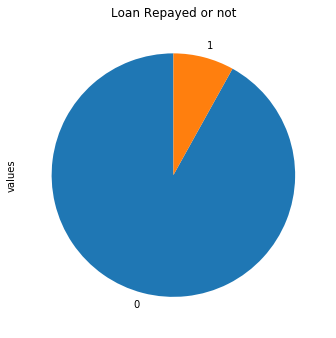

In [73]:
plt.figure(figsize=(12,6))
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
ax1 = plt.subplot(121, aspect='equal')
df.plot(kind='pie', y='values', ax=ax1, startangle=90, legend = False, title='Loan Repayed or not');

This is an imbalanced class problem. 0 represents loan being repaid and 1 represents loan not being repaid. We might need resampling methods or adjusting the weights in machine learning modeling.

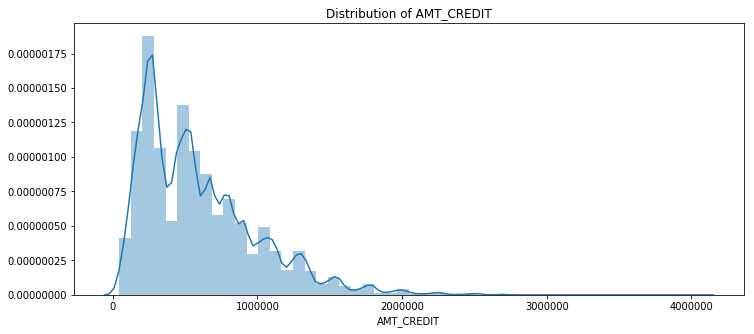

In [50]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

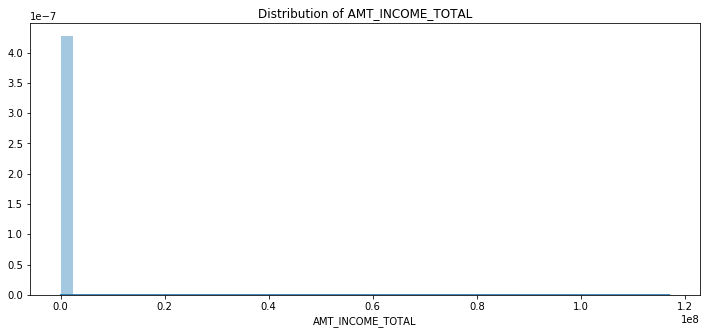

In [52]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(application_train["AMT_INCOME_TOTAL"])

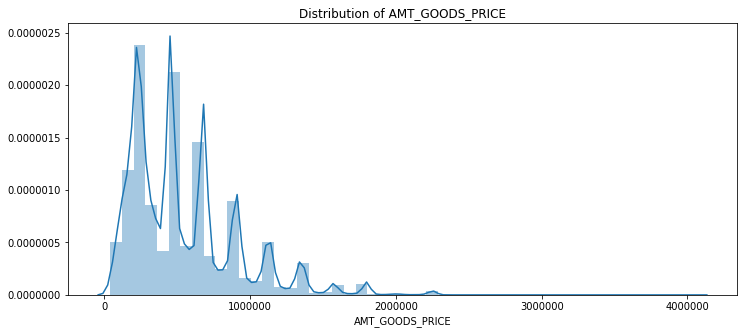

In [55]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

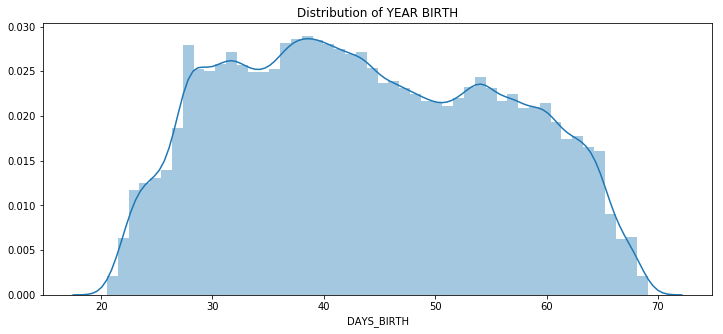

In [76]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR BIRTH")
ax = sns.distplot(application_train['DAYS_BIRTH'] / -365)

### Anomalies

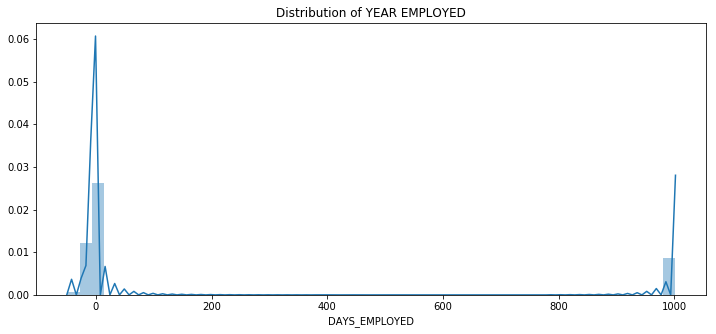

In [4]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR EMPLOYED")
ax = sns.distplot(application_train['DAYS_EMPLOYED']/365)

That doesn't make sense. Some people were employed 1000 years!

In [5]:
application_train[application_train['DAYS_EMPLOYED'] != 365243]['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [6]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


The anomalies have a lower rate of default. We will replace the anomaly values with na and create a new column flagging the anomalies

In [7]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

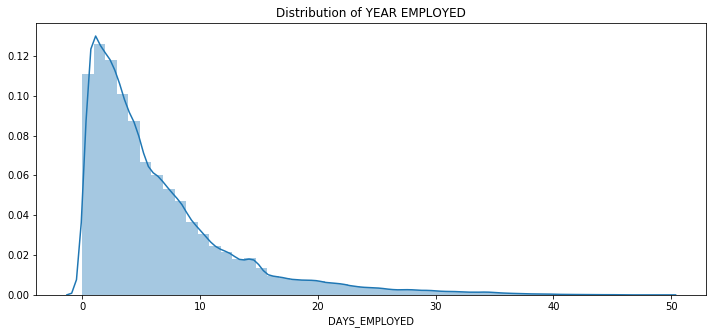

In [8]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR EMPLOYED")
ax = sns.distplot(application_train['DAYS_EMPLOYED'].dropna()/-365)

In [9]:
# update the test set as well
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Correlation

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [29]:
correlations = application_train.select_dtypes(include=numerics).corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 has strongest negative relationship with the target and DAYS_BIRTH has the strongest positive relationship with the target.

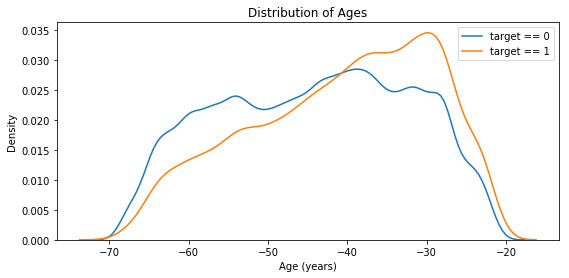

In [10]:
plt.figure(figsize = (9, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Loans not repaid line skewed towards younger age than loans repaid

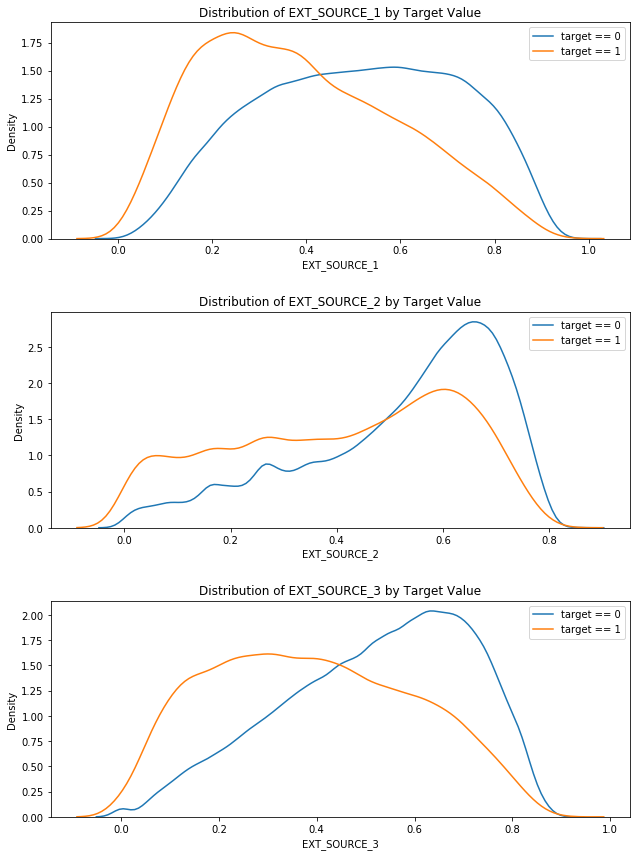

In [8]:
plt.figure(figsize = (9, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Examine missing value

In [91]:
def missing_value_table(df):
    # number of missing values
    na_totals = df.isnull().sum()
    # percentage of missing values
    na_percent = 100 * df.isnull().sum() / len(df)
    # create a table
    na_table = pd.concat([na_totals, na_percent], axis=1)
    
    na_table_rename = na_table.rename(
        columns = {0 : '# of Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    na_table_rename = na_table_rename[
        na_table_rename.iloc[:,1] != 0].sort_values(by=['% of Total Values'],ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(na_table_rename.shape[0]) +
           " columns that have missing values.")
    return na_table_rename

In [92]:
missing_value_table(application_train).head(10)

Your selected dataframe has 241 columns.
There are 62 columns that have missing values.


,# of Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_MODE,208642,67.8


No need to impute data for now, as random forest and xgboost can handle missing values

### Columns of Object type

In [34]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Number of unique classes in each object column

In [35]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Text(0.5,1,'Percentage of default by NAME_CONTRACT_TYPE')

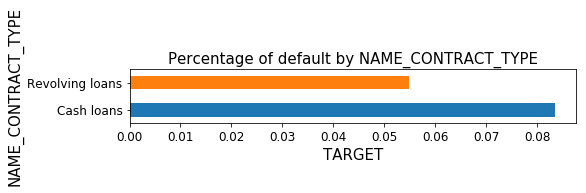

In [11]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['NAME_CONTRACT_TYPE'])['TARGET'].mean().plot('barh',figsize = (8,1),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('NAME_CONTRACT_TYPE',fontsize = 15)
plt.title('Percentage of default by NAME_CONTRACT_TYPE', fontsize = 15)

In [16]:
application_train['NAME_CONTRACT_TYPE'].value_counts() 

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

At first sight of the plot, it seems that revolving loans have lower default rates. However, the value_counts result shows that only a small percentage of loans are of revolving loans. So we cannot conclude that revolving loans have lower default rates.